In [1]:
#importando as bibliotecas
import folium
import json
import pandas as pd
from pandas import json_normalize
import geopandas as gpd
import xml.etree.cElementTree as etree
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from haversine import haversine
import numpy as np
import os
import matplotlib.pyplot as plt

/home/vinicius.vancellote/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Abrindo o Arquivo GeoJson com o limite das Zonas Pluviometricas
zonasgpd = gpd.read_file('/home/vinicius.vancellote/Codigos_Python/Bases/EstacoesPluviometricas/Zonas_Pluviometricas.geojson')

In [3]:
zonasgpd2 = zonasgpd[['OBJECTID','geometry']]

In [4]:
# ler todos os arquivos csv do diretório e guardar em um objeto
all_files = os.listdir('/home/vinicius.vancellote/data/json')

In [5]:
del all_files[1]

In [6]:
all_files

['G1-2019-05-28.json',
 'G1-2019-03-10.json',
 'G1-2019-03-26.json',
 'G1-2019-04-06.json',
 'G1-2019-05-22.json']

In [7]:
#realizar a leitura para cada arquivo
full_dataset = []
for elem in all_files:
    data = pd.read_json('/home/vinicius.vancellote/data/json/'+ elem)
    full_dataset.append(data)

In [8]:
#Concatenando em um único Dataframe
dfbus = pd.concat(full_dataset,axis=0,ignore_index=True)

In [9]:
#Tratando para poder fazer o Join no GeoJson
dfbus['LATITUDE'] = dfbus['LATITUDE'].astype(str)
dfbus['LONGITUDE'] = dfbus['LONGITUDE'].astype(str)

In [10]:
#Criando uma coluna chamada Geometry para ficar similar ao GeoJson
dfbus = dfbus.assign(geometry = ('POINT Z (' + dfbus['LONGITUDE'] + ' ' + dfbus['LATITUDE'] + ' ' + '0.00000)'))

In [11]:
#Transformando o dfbus em um GeoJson com a mesma codificação do ZonasPluviometricas
cp_union = gpd.GeoDataFrame(
    dfbus.loc[:, [c for c in dfbus.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(dfbus["geometry"]),
    crs="epsg:4326",
)

In [12]:
dfjoin = gpd.sjoin(cp_union,zonasgpd2,how='left')

In [13]:
#dfjoin

In [14]:
#dfjoin.dtypes

In [15]:
dfjoin['Data'] = pd.to_datetime(dfjoin['DATE']).dt.normalize()

In [16]:
dfjoin['Hora']=dfjoin['DATE'].dt.hour

In [17]:
dfout = dfjoin[dfjoin['OBJECTID'].isnull()]

In [18]:
dfout

,df_index,DATE,BUSID,LINE,LATITUDE,LONGITUDE,Distancia,VELOCITY,geometry,index_right,OBJECTID,Data,Hora
15816,2750461,2019-05-28 13:55:05,A27566,548.0,-23.006281,-43.281441,2025.631819,75.0,POINT Z (-43.28144 -23.00628 0.00000),NaN,NaN,2019-05-28,13
48449,2283763,2019-05-28 05:25:32,A29005,SP513,-22.948,-43.165081,52.789923,20.0,POINT Z (-43.16508 -22.94800 0.00000),NaN,NaN,2019-05-28,5
48475,3936792,2019-05-28 06:27:03,A29005,SP513,-22.94591,-43.163639,113.719086,24.0,POINT Z (-43.16364 -22.94591 0.00000),NaN,NaN,2019-05-28,6
48477,3212680,2019-05-28 06:28:41,A29005,SP513,-22.94816,-43.165291,174.005864,29.0,POINT Z (-43.16529 -22.94816 0.00000),NaN,NaN,2019-05-28,6
48478,1845903,2019-05-28 06:29:49,A29005,SP513,-22.9515,-43.168678,508.140644,23.0,POINT Z (-43.16868 -22.95150 0.00000),NaN,NaN,2019-05-28,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17732069,408421,2019-05-22 13:51:41,D87362,898.0,-22.987190000000002,-43.688419,259.356007,1.0,POINT Z (-43.68842 -22.98719 0.00000),NaN,NaN,2019-05-22,13
17732623,1528439,2019-05-22 12:01:18,D87395,898.0,-22.98715,-43.688389,610.949834,4.0,POINT Z (-43.68839 -22.98715 0.00000),NaN,NaN,2019-05-22,12
17733272,3894562,2019-05-22 04:09:55,D87396,,-22.9877,-43.688782,244.616534,24.0,POINT Z (-43.68878 -22.98770 0.00000),NaN,NaN,2019-05-22,4
17733570,3173960,2019-05-22 09:40:38,D87396,898.0,-22.987190000000002,-43.6884,36.578985,0.0,POINT Z (-43.68840 -22.98719 0.00000),NaN,NaN,2019-05-22,9


In [19]:
dfRJ = dfjoin[dfjoin['OBJECTID'].notnull()]

In [34]:
dfRJ

,df_index,DATE,BUSID,LINE,LATITUDE,LONGITUDE,Distancia,VELOCITY,geometry,index_right,OBJECTID,Data,Hora
0,2480330,2019-05-28 00:23:42,A27506,439.0,-22.91995,-43.256618,0.000000,0.0,POINT Z (-43.25662 -22.91995 0.00000),6.0,7.0,2019-05-28,0
1,2471253,2019-05-28 00:24:42,A27506,439.0,-22.91995,-43.256618,0.000000,0.0,POINT Z (-43.25662 -22.91995 0.00000),6.0,7.0,2019-05-28,0
2,4066229,2019-05-28 00:25:41,A27506,439.0,-22.91995,-43.256618,0.000000,0.0,POINT Z (-43.25662 -22.91995 0.00000),6.0,7.0,2019-05-28,0
3,2279978,2019-05-28 00:26:41,A27506,439.0,-22.91995,-43.256618,0.000000,0.0,POINT Z (-43.25662 -22.91995 0.00000),6.0,7.0,2019-05-28,0
4,2963761,2019-05-28 00:27:41,A27506,439.0,-22.91995,-43.256618,0.000000,0.0,POINT Z (-43.25662 -22.91995 0.00000),6.0,7.0,2019-05-28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17780048,3614919,2019-05-22 21:48:13,D87894,2307.0,-22.917191,-43.60849,0.000000,39.0,POINT Z (-43.60849 -22.91719 0.00000),25.0,26.0,2019-05-22,21
17780049,2141194,2019-05-22 22:18:13,D87894,2307.0,-22.917191,-43.60849,0.000000,39.0,POINT Z (-43.60849 -22.91719 0.00000),25.0,26.0,2019-05-22,22
17780050,2654219,2019-05-22 22:48:13,D87894,2307.0,-22.917259,-43.608398,12.081220,0.0,POINT Z (-43.60840 -22.91726 0.00000),25.0,26.0,2019-05-22,22
17780051,2512102,2019-05-22 23:18:13,D87894,2307.0,-22.91716,-43.608501,15.246839,0.0,POINT Z (-43.60850 -22.91716 0.00000),25.0,26.0,2019-05-22,23


In [32]:
dfgroup = dfRJ.groupby(["Data"],as_index=False)["Distancia"].sum()

In [33]:
dfgroup

,Data,Distancia
0,2019-03-10,8.225354e+07
1,2019-03-26,1.153822e+09
2,2019-04-06,8.884546e+08
3,2019-05-22,1.139344e+09
4,2019-05-28,1.162067e+09


In [22]:
dfgroupbom = dfgroup[(dfgroup["Data"]=='2019-03-30')| (dfgroup["Data"]=='2019-04-06') | (dfgroup["Data"]=='2019-05-22') | (dfgroup["Data"]=='2019-05-28')]

In [36]:
dfgroupbom.mean()

/tmp/ipykernel_22004/2449837811.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dfgroupbom.mean()


OBJECTID     1.700000e+01
Distancia    3.222086e+07
dtype: float64

In [23]:
dfgroupruim = dfgroup[(dfgroup["Data"]=='2019-03-10')| (dfgroup["Data"]=='2019-03-26')]

In [37]:
dfgroupruim.mean()

/tmp/ipykernel_22004/2014122078.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dfgroupruim.mean()


OBJECTID     1.700000e+01
Distancia    1.872842e+07
dtype: float64

In [38]:
dfgroupruim.stdev()

AttributeError: 'DataFrame' object has no attribute 'stdev'

In [25]:
dfgroup2 = dfRJ.groupby(["Data"],as_index=False)["Distancia"].sum()

<BarContainer object of 99 artists>

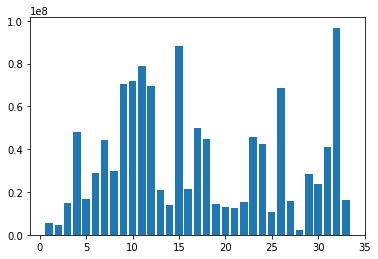

In [26]:
plt.bar(dfgroupbom["OBJECTID"],dfgroupbom["Distancia"])

<BarContainer object of 66 artists>

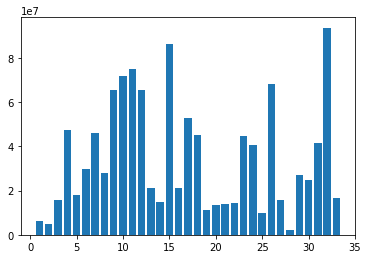

In [27]:
plt.bar(dfgroupruim["OBJECTID"],dfgroupruim["Distancia"])

In [28]:
dfzona = dfgroup[dfgroup["OBJECTID"]==12.0]

In [29]:
dfzona

,Data,OBJECTID,Distancia
11,2019-03-10,12.0,5.919786e+06
44,2019-03-26,12.0,6.553835e+07
77,2019-04-06,12.0,5.563484e+07
110,2019-05-22,12.0,6.525063e+07
143,2019-05-28,12.0,6.946818e+07


<BarContainer object of 5 artists>

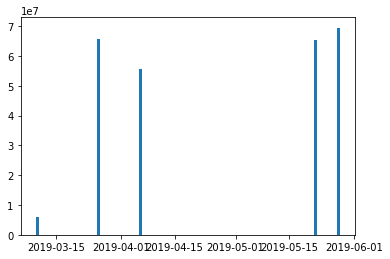

In [30]:
plt.bar(dfzona["Data"],dfzona["Distancia"])

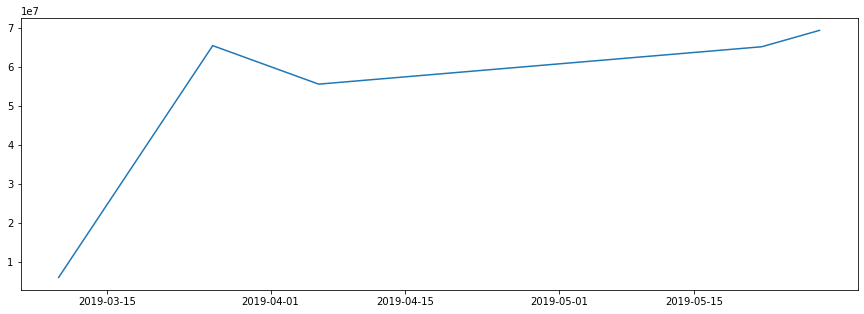

In [31]:
fig = plt.figure(figsize=(15,5))
plt.plot(dfzona["Data"],dfzona["Distancia"])